In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras import regularizers

In [3]:
data= pd.read_csv('/content/hour.csv')
data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [4]:
ohe_features = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for feature in ohe_features:
    dummies = pd.get_dummies(data[feature], prefix=feature, drop_first=False)
    data = pd.concat([data, dummies], axis=1)
    drop_features = ['instant', 'dteday', 'season', 'weathersit','weekday', 'atemp', 'mnth', 'workingday', 'hr', 'casual', 'registered']
data=data.drop(drop_features, axis=1)

In [7]:
norm_features = ['cnt', 'temp', 'hum', 'windspeed']
scaled_features = {}
for feature in norm_features:
  mean, std = data[feature].mean(), data[feature].std()
  scaled_features[feature] = [mean, std]
  data.loc[:, feature] = (data[feature] - mean)/std

In [9]:
test_data = data[-31*24:]
data = data[:-31*24]

In [12]:
target_fields = ['cnt']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [13]:
X_train, y_train = features[:-30*24], targets[:-30*24]

In [14]:
X_val, y_val = features[-30*24:], targets[-30*24:]

In [32]:
X_train.shape

(15915, 56)

In [31]:
y_train.shape

(15915, 1)

In [15]:
model = Sequential()
model.add(Dense(250, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='linear'))

In [16]:
model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

In [20]:
n_epochs = 500
batch_size = 50
# Convert DataFrames to NumPy arrays with float32 data type
history = model.fit(X_train.values.astype('float32'), y_train['cnt'].values.astype('float32'),
                    validation_data=(X_val.values.astype('float32'), y_val['cnt'].values.astype('float32')),
                    batch_size=batch_size, epochs=n_epochs, verbose=0)

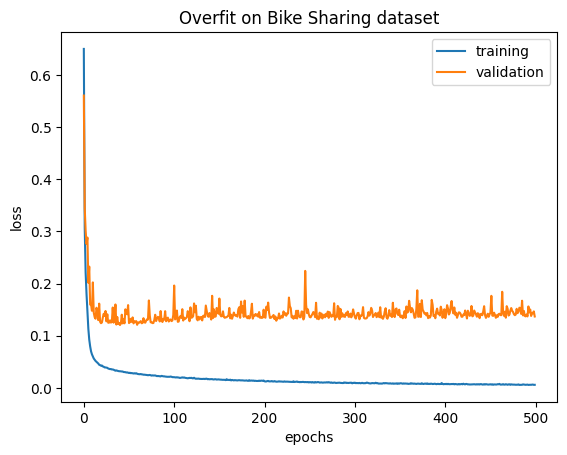

In [21]:
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'],label='training')
plt.plot(np.arange(len(history.history['val_loss'])), history.history['val_loss'], label='validation')
plt.title('Overfit on Bike Sharing dataset')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc=0)
plt.show()

In [22]:
print('Minimum loss: ', min(history.history['val_loss']),
'\nAfter ', np.argmin(history.history['val_loss']), ' epochs')

Minimum loss:  0.12044798582792282 
After  40  epochs


In [23]:
model_reg = Sequential()
model_reg.add(Dense(250, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model_reg.add(Dense(150, activation='relu'))
model_reg.add(Dense(50, activation='relu'))
model_reg.add(Dense(25, activation='relu',kernel_regularizer=regularizers.l2(0.005)))
model_reg.add(Dense(1, activation='linear'))

In [24]:
model_reg.compile(loss='mse', optimizer='sgd', metrics=['mse'])

In [26]:
history_reg = model_reg.fit(X_train.values.astype('float32'),
                             y_train['cnt'].values.astype('float32'),
                             validation_data=(X_val.values.astype('float32'),
                                              y_val['cnt'].values.astype('float32')),
                             batch_size=batch_size,
                             epochs=n_epochs,
                             verbose=0)

In [28]:
print('Minimum Loss: ',min(history_reg.history['val_loss']))
print('After ',np.argmin(history_reg.history['val_loss']),' epochs')

Minimum Loss:  0.1327648013830185
After  437  epochs
